<a href="https://colab.research.google.com/github/rajanaids-hub/Reinforcement_Learning_Lab/blob/main/Maze_Agent_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training Agent...
Training complete! Q-Table size: 95 state-action pairs.
Optimal Path: [(np.int64(0), np.int64(0)), (np.int64(1), np.int64(0)), (np.int64(2), np.int64(0)), (np.int64(3), np.int64(0)), (np.int64(3), np.int64(1)), (np.int64(3), np.int64(2)), (np.int64(4), np.int64(2)), (np.int64(5), np.int64(2)), (np.int64(5), np.int64(3)), (np.int64(5), np.int64(4)), (np.int64(5), np.int64(5))]


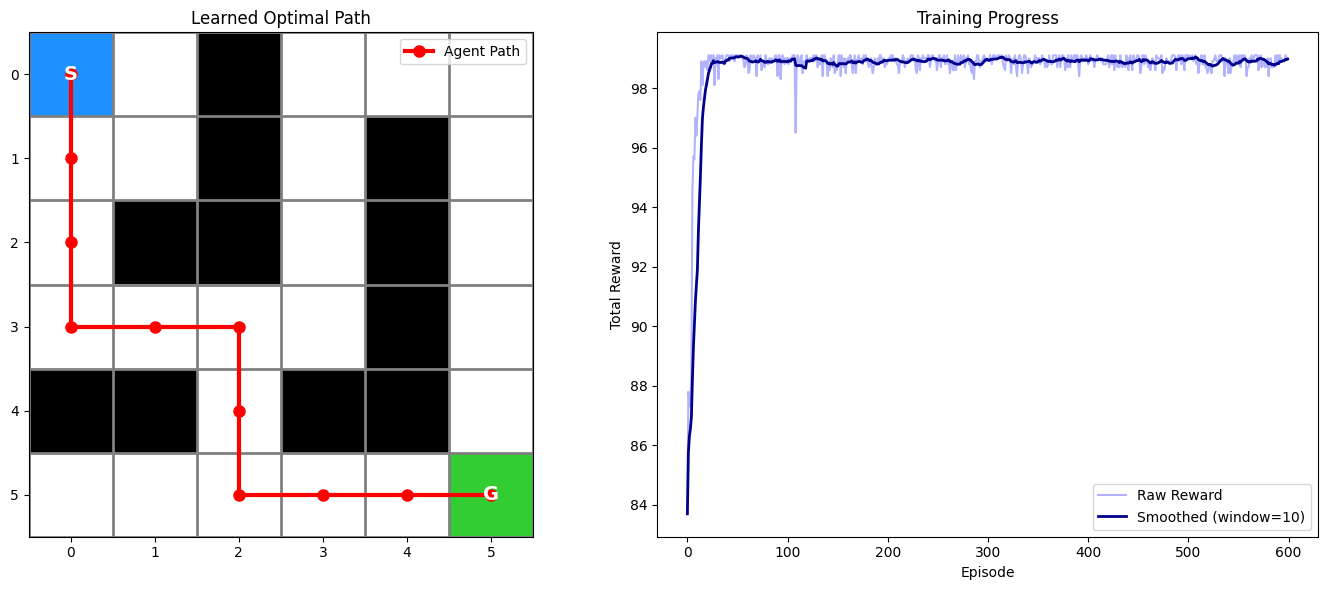

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import colors

# 1. Define the Maze Layout
# 'S' = Start, 'G' = Goal, '0' = Free Path, '1' = Wall/Obstacle
maze_layout = [
    ['S', '0', '1', '0', '0', '0'],
    ['0', '0', '1', '0', '1', '0'],
    ['0', '1', '1', '0', '1', '0'],
    ['0', '0', '0', '0', '1', '0'],
    ['1', '1', '0', '1', '1', '0'],
    ['0', '0', '0', '0', '0', 'G']
]

# 2. Define the Environment
class MazeEnvironment:
    def __init__(self, maze):
        self.maze = np.array(maze)
        self.rows, self.cols = self.maze.shape
        self.start = tuple(np.argwhere(self.maze == 'S')[0])
        self.goal = tuple(np.argwhere(self.maze == 'G')[0])
        self.state = self.start

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        # Actions: 0: Up, 1: Right, 2: Down, 3: Left
        r, c = self.state
        if action == 0: r -= 1
        elif action == 1: c += 1
        elif action == 2: r += 1
        elif action == 3: c -= 1

        # Check boundaries and walls (if invalid, agent stays in place)
        if (0 <= r < self.rows) and (0 <= c < self.cols) and (self.maze[r, c] != '1'):
            self.state = (r, c)

        done = (self.state == self.goal)

        # Reward structure: +100 for Goal, -0.1 for each step to penalize long paths
        reward = 100 if done else -0.1

        return self.state, reward, done

# 3. Define the Q-Learning Agent
class QLearningAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.q_table = {}
        self.actions = actions
        self.alpha = alpha       # Learning rate
        self.gamma = gamma       # Discount factor (values future rewards)
        self.epsilon = epsilon   # Exploration rate

    def get_q(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state, explore=True):
        # Epsilon-greedy exploration
        if explore and random.uniform(0, 1) < self.epsilon:
            return random.choice(self.actions)

        # Exploitation (choose best known action)
        q_values = [self.get_q(state, a) for a in self.actions]
        max_q = max(q_values)

        # Handle ties randomly
        best_actions = [a for a, q in zip(self.actions, q_values) if q == max_q]
        return random.choice(best_actions)

    def learn(self, state, action, reward, next_state):
        # Bellman Equation
        old_q = self.get_q(state, action)
        next_max_q = max([self.get_q(next_state, a) for a in self.actions])

        new_q = old_q + self.alpha * (reward + self.gamma * next_max_q - old_q)
        self.q_table[(state, action)] = new_q

# 4. Training Loop
if __name__ == '__main__':
    env = MazeEnvironment(maze_layout)
    # Actions: 0=Up, 1=Right, 2=Down, 3=Left
    agent = QLearningAgent(actions=[0, 1, 2, 3], alpha=0.2, gamma=0.95, epsilon=0.15)

    episodes = 600
    rewards_per_episode = []

    print("Training Agent...")
    for ep in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        steps = 0

        while not done and steps < 200: # Max 200 steps to prevent infinite loops
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)

            agent.learn(state, action, reward, next_state)

            state = next_state
            total_reward += reward
            steps += 1

        rewards_per_episode.append(total_reward)

    print(f"Training complete! Q-Table size: {len(agent.q_table)} state-action pairs.")

    # 5. Evaluate and Generate Path
    state = env.reset()
    done = False
    optimal_path = [state]
    steps = 0

    while not done and steps < 50:
        action = agent.choose_action(state, explore=False) # Strictly exploit learned policy
        next_state, _, done = env.step(action)
        state = next_state
        optimal_path.append(state)
        steps += 1

    print("Optimal Path:", optimal_path)

    # 6. Visualization
    grid = np.zeros((len(maze_layout), len(maze_layout[0])))
    for r in range(len(maze_layout)):
        for c in range(len(maze_layout[0])):
            if maze_layout[r][c] == '1': grid[r, c] = 1        # Wall
            elif maze_layout[r][c] == 'S': grid[r, c] = 0.2    # Start
            elif maze_layout[r][c] == 'G': grid[r, c] = 0.8    # Goal

    cmap = colors.ListedColormap(['white', 'dodgerblue', 'limegreen', 'black'])
    bounds = [0, 0.1, 0.5, 0.9, 1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Maze and Path
    ax1.imshow(grid, cmap=cmap, norm=norm)
    ax1.set_title('Learned Optimal Path')

    # Grid lines
    ax1.set_xticks(np.arange(-.5, len(maze_layout[0]), 1), minor=True)
    ax1.set_yticks(np.arange(-.5, len(maze_layout), 1), minor=True)
    ax1.grid(which='minor', color='gray', linestyle='-', linewidth=2)
    ax1.tick_params(which='minor', bottom=False, left=False)

    # Path
    path_y = [p[0] for p in optimal_path]
    path_x = [p[1] for p in optimal_path]
    ax1.plot(path_x, path_y, marker='o', color='red', markersize=8, linewidth=3, label='Agent Path')
    ax1.legend()

    # Labels
    for r in range(len(maze_layout)):
        for c in range(len(maze_layout[0])):
            if maze_layout[r][c] == 'S': ax1.text(c, r, 'S', ha='center', va='center', color='white', fontweight='bold', fontsize=14)
            elif maze_layout[r][c] == 'G': ax1.text(c, r, 'G', ha='center', va='center', color='white', fontweight='bold', fontsize=14)

    # Plot Rewards
    window = 10
    smoothed_rewards = [np.mean(rewards_per_episode[max(0, i-window):(i+1)]) for i in range(len(rewards_per_episode))]
    ax2.plot(rewards_per_episode, alpha=0.3, color='blue', label='Raw Reward')
    ax2.plot(smoothed_rewards, color='darkblue', linewidth=2, label=f'Smoothed (window={window})')
    ax2.set_title('Training Progress')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Total Reward')
    ax2.legend()

    plt.tight_layout()
    plt.show()